In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

from google.colab import drive
%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = "/content/drive/MyDrive/Datathon/dataset/covid_mental_health_train.csv"
test_dir = "/content/drive/MyDrive/Datathon/dataset/covid_mental_health_test.csv"

In [4]:
train_df = pd.read_csv(train_dir)
print(train_df.head(5))
print(train_df.shape)
print(train_df.columns)

           id  city  gender  ...  difficulty_living  difficulty_work  depression
0  1963059261     1       1  ...                  6                5           0
1   591108995     4       1  ...                  4                5           0
2   613190420     2       1  ...                  1                1           0
3  1011726889     7       1  ...                  1                1           0
4   345550215     2       1  ...                  1                4           0

[5 rows x 29 columns]
(8610, 29)
Index(['id', 'city', 'gender', 'age', 'job', 'health_worker_self',
       'health_worker_family', 'family_status', 'income_group',
       'current_physical', 'past_physical', 'current_mental', 'past_mental',
       'exercise', 'healthy_diet', 'healthy_sleep', 'activity',
       'interaction_offline', 'interaction_online', 'preventive_behaviors',
       'optimism', 'deterioration_economy', 'deterioration_interact',
       'frustration', 'covid_anxiety', 'covid_sleepless', 'dif

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      8610 non-null   int64  
 1   city                    8610 non-null   int64  
 2   gender                  8610 non-null   int64  
 3   age                     8610 non-null   int64  
 4   job                     8610 non-null   int64  
 5   health_worker_self      8610 non-null   int64  
 6   health_worker_family    8610 non-null   int64  
 7   family_status           8610 non-null   int64  
 8   income_group            7282 non-null   float64
 9   current_physical        8610 non-null   int64  
 10  past_physical           8610 non-null   int64  
 11  current_mental          8610 non-null   int64  
 12  past_mental             8610 non-null   int64  
 13  exercise                8610 non-null   int64  
 14  healthy_diet            8610 non-null   

In [6]:
train_df.describe()

,id,city,gender,age,job,health_worker_self,health_worker_family,family_status,income_group,current_physical,past_physical,current_mental,past_mental,exercise,healthy_diet,healthy_sleep,activity,interaction_offline,interaction_online,preventive_behaviors,optimism,deterioration_economy,deterioration_interact,frustration,covid_anxiety,covid_sleepless,difficulty_living,difficulty_work,depression
count,8.610000e+03,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,7282.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000,8610.000000
mean,1.072829e+09,3.424274,1.525784,46.088269,1.649826,1.939721,1.911498,1.619628,4.308981,1.956330,1.923461,1.942857,1.879443,4.150871,4.261324,4.506039,4.016492,3.606969,3.432288,5.245412,4.046690,3.849361,2.706272,3.461208,4.031243,2.754704,3.697909,3.871893,0.180488
std,6.189227e+08,2.008436,0.499364,14.727426,1.118760,0.238016,0.284040,0.485506,2.653107,0.204372,0.265874,0.232129,0.325631,1.850211,1.663113,1.868178,1.748492,1.900107,2.040678,1.872720,1.663155,1.873872,1.766552,1.829900,1.767684,1.753610,1.888003,2.048310,0.384616
min,3.652360e+05,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,5.360256e+08,2.000000,1.000000,34.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000,4.000000,3.000000,2.000000,1.000000,2.000000,3.000000,1.000000,2.000000,2.000000,0.000000
50%,1.079098e+09,3.000000,2.000000,46.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,6.000000,4.000000,4.000000,2.000000,4.000000,4.000000,2.000000,4.000000,4.000000,0.000000
75%,1.603533e+09,5.000000,2.000000,57.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,7.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,0.000000
max,2.147087e+09,7.000000,2.000000,89.000000,5.000000,2.000000,2.000000,2.000000,10.000000,2.000000,2.000000,2.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000000


In [7]:
total_cells = np.product(train_df.shape)
total_missing = train_df.isna().sum().sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print("percent of missing value in dataset : ", percent_missing)

percent of missing value in dataset :  0.5318595057871761


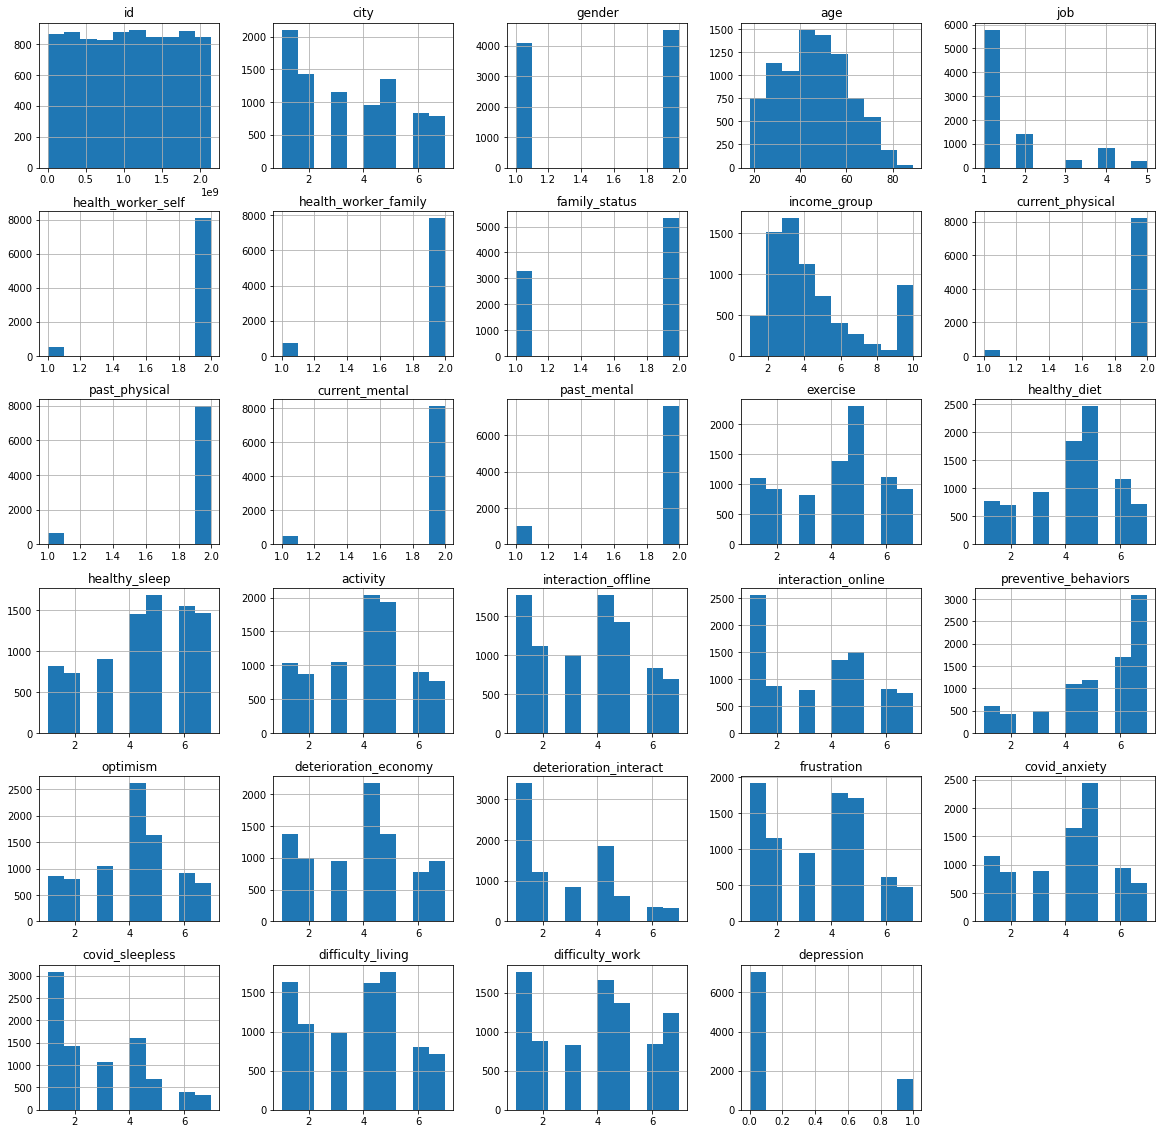

In [8]:
train_df.hist(figsize=(20,20))
plt.show()

city                         AxesSubplot(0.125,0.787927;0.168478x0.0920732)
gender                    AxesSubplot(0.327174,0.787927;0.168478x0.0920732)
age                       AxesSubplot(0.529348,0.787927;0.168478x0.0920732)
job                       AxesSubplot(0.731522,0.787927;0.168478x0.0920732)
health_worker_self           AxesSubplot(0.125,0.677439;0.168478x0.0920732)
health_worker_family      AxesSubplot(0.327174,0.677439;0.168478x0.0920732)
family_status             AxesSubplot(0.529348,0.677439;0.168478x0.0920732)
income_group              AxesSubplot(0.731522,0.677439;0.168478x0.0920732)
current_physical             AxesSubplot(0.125,0.566951;0.168478x0.0920732)
past_physical             AxesSubplot(0.327174,0.566951;0.168478x0.0920732)
current_mental            AxesSubplot(0.529348,0.566951;0.168478x0.0920732)
past_mental               AxesSubplot(0.731522,0.566951;0.168478x0.0920732)
exercise                     AxesSubplot(0.125,0.456463;0.168478x0.0920732)
healthy_diet

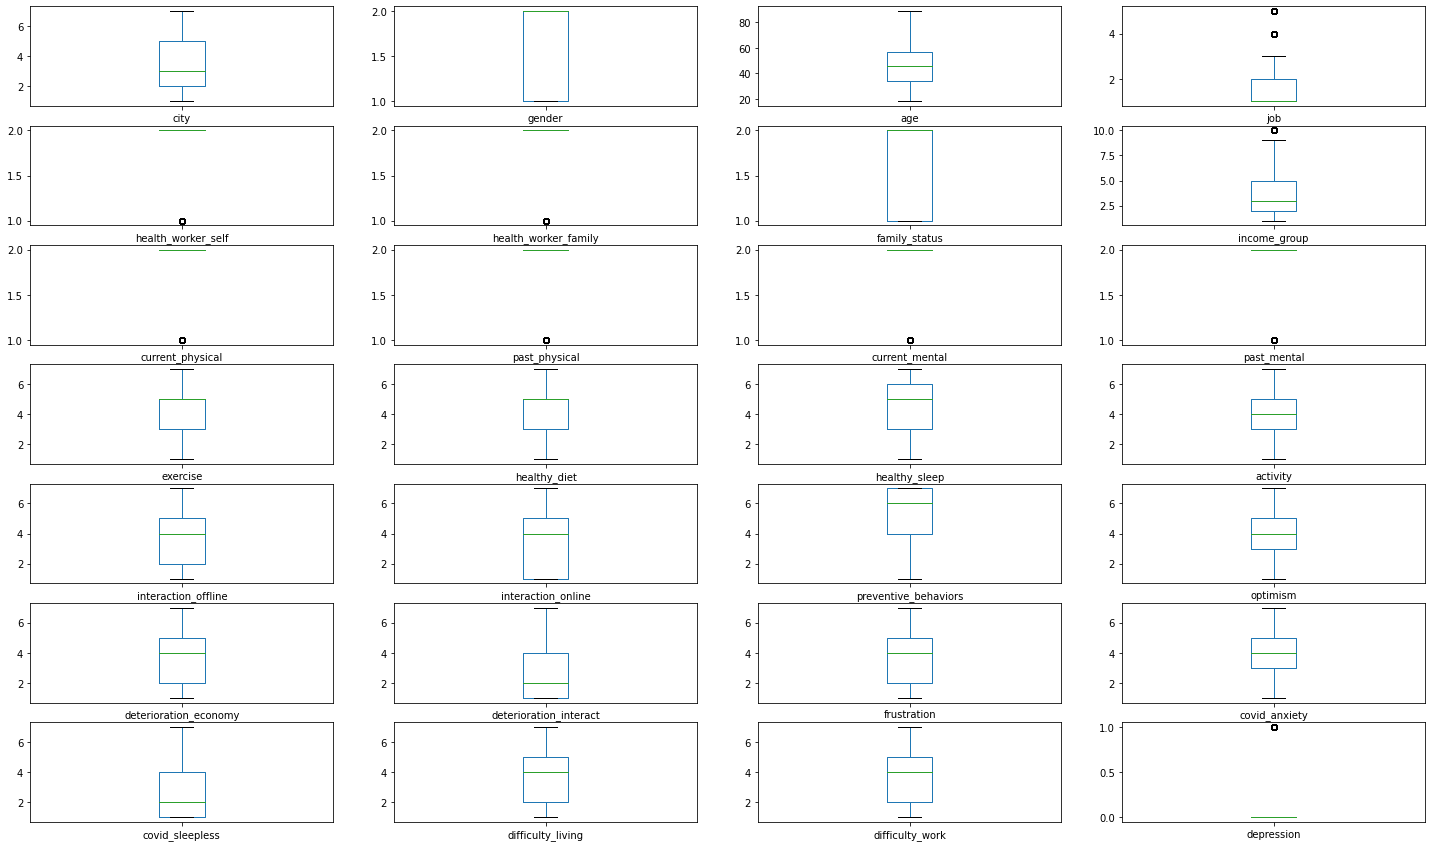

In [9]:
colmn = ['city', 'gender', 'age', 'job', 'health_worker_self',
       'health_worker_family', 'family_status', 'income_group',
       'current_physical', 'past_physical', 'current_mental', 'past_mental',
       'exercise', 'healthy_diet', 'healthy_sleep', 'activity',
       'interaction_offline', 'interaction_online', 'preventive_behaviors',
       'optimism', 'deterioration_economy', 'deterioration_interact',
       'frustration', 'covid_anxiety', 'covid_sleepless', 'difficulty_living',
       'difficulty_work', 'depression']

train_df[colmn].plot(kind="box", subplots = True, layout = (7, 4), figsize = (25, 15))

In [10]:
train_df.income_group = train_df['income_group'].interpolate(method='linear')

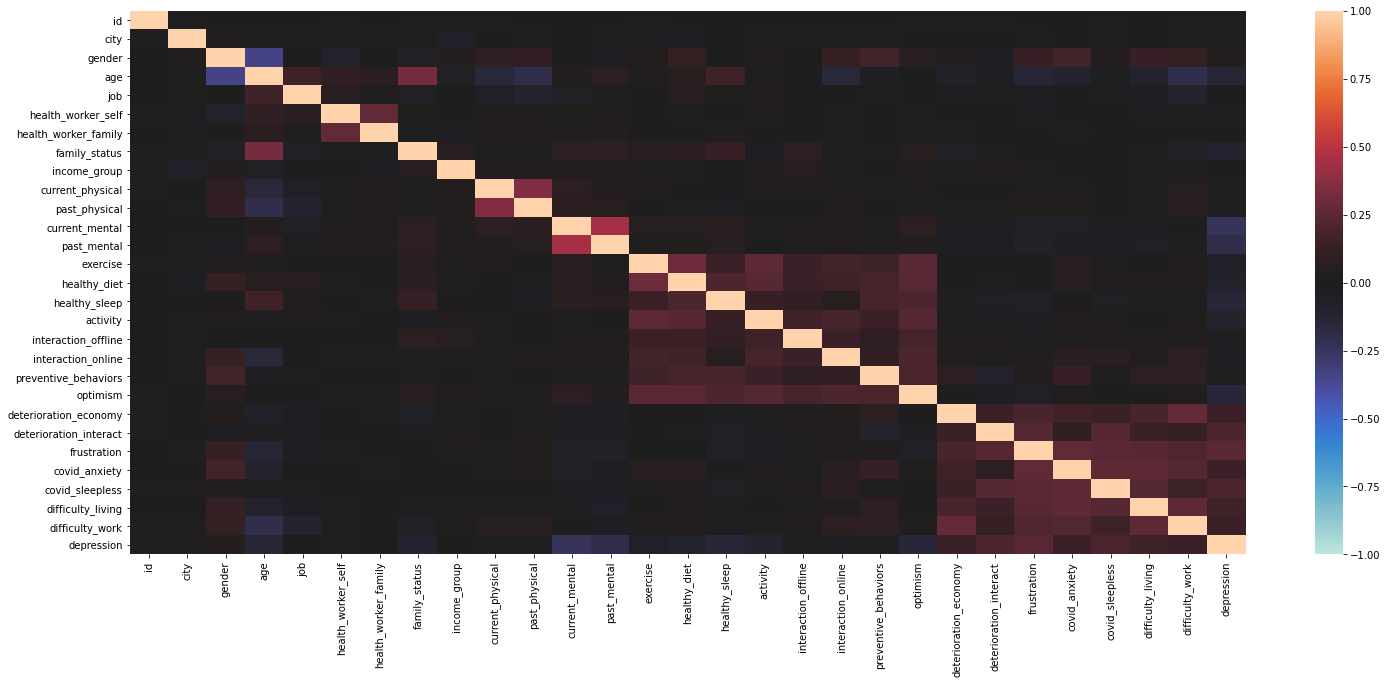

In [11]:
plt.figure(figsize=(25, 10))
sns.heatmap(train_df.corr(), annot= False, vmin=-1, vmax=1, center=0)

0.22023809523809523
Depressed People :  1554
Not Depressed People :  7056


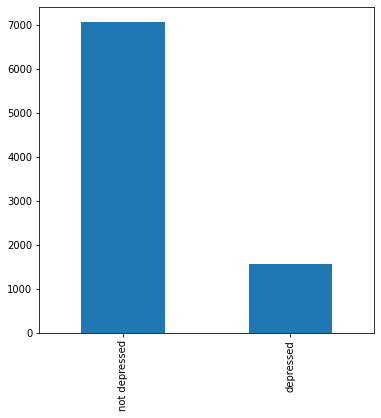

In [12]:
train_df['depression'].value_counts().plot(kind='bar', figsize = (6, 6))
plt.xticks([0, 1], ['not depressed', 'depressed'])

depressed = train_df[train_df['depression'] == 1]
not_depressed = train_df[train_df['depression'] == 0]

outlier_fraction = len(depressed)/ float(len(not_depressed))
print(outlier_fraction)
print("Depressed People : ", len(depressed))
print("Not Depressed People : ", len(not_depressed))

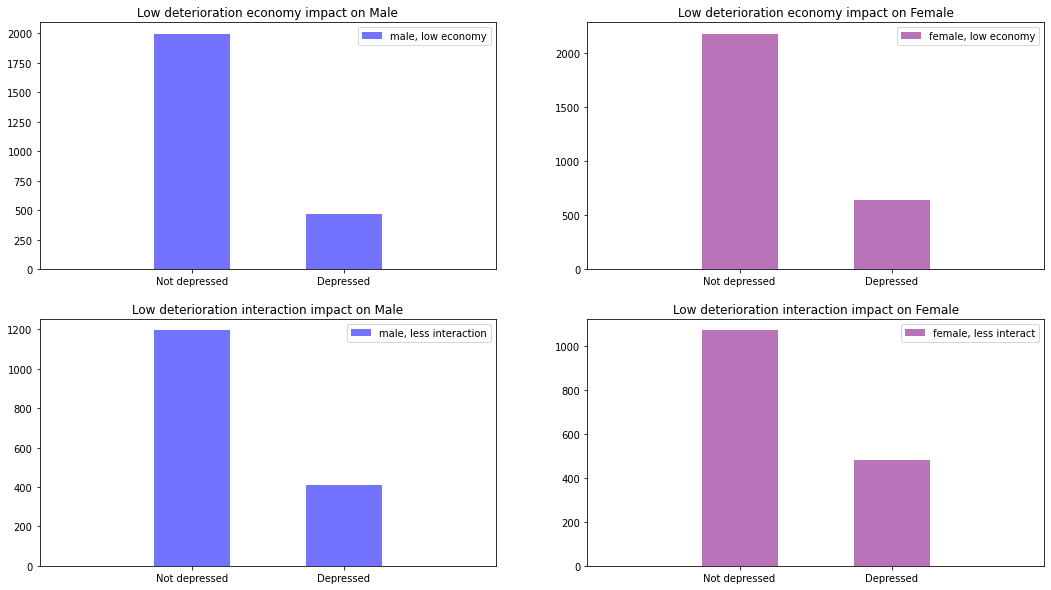

In [13]:
plt.figure(figsize=(18, 10))
plt.subplot(2,2,1)
male_economy = train_df.depression[train_df.gender == 1][train_df.deterioration_economy >= 4].value_counts()
male_economy.plot(kind='bar', label='male, low economy', alpha=0.55, color='blue')
plt.title("Low deterioration economy impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_economy))
plt.legend(loc='best')

plt.subplot(2,2,2)
female_economy = train_df.depression[train_df.gender == 2][train_df.deterioration_economy >= 4].value_counts()
female_economy.plot(kind='bar', label='female, low economy', alpha=0.55, color='purple')
plt.title("Low deterioration economy impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_economy))
plt.legend(loc='best')

plt.subplot(2,2,3)
male_interact = train_df.depression[train_df.gender == 1][train_df.deterioration_interact >= 4].value_counts()
male_interact.plot(kind='bar', label='male, less interaction', alpha=0.55, color='blue')
plt.title("Low deterioration interaction impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_interact))
plt.legend(loc='best')

plt.subplot(2,2,4)
female_interact = train_df.depression[train_df.gender == 2][train_df.deterioration_interact >= 4].value_counts()
female_interact.plot(kind='bar', label='female, less interact', alpha=0.55, color='purple')
plt.title("Low deterioration interaction impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_interact))
plt.legend(loc='best')

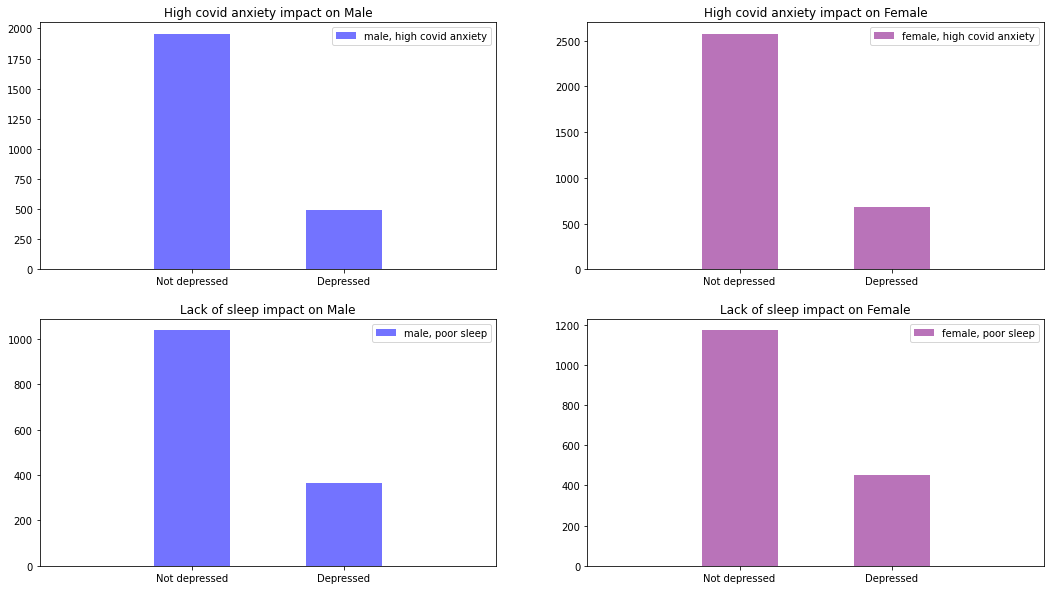

In [14]:
plt.figure(figsize=(18, 10))
plt.subplot(2,2,1)
male_covid_anxiety = train_df.depression[train_df.gender == 1][train_df.covid_anxiety >= 4].value_counts()
male_covid_anxiety.plot(kind='bar', label='male, high covid anxiety', alpha=0.55, color='blue')
plt.title("High covid anxiety impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_covid_anxiety))
plt.legend(loc='best')

plt.subplot(2,2,2)
female_covid_anxiety = train_df.depression[train_df.gender == 2][train_df.covid_anxiety >= 4].value_counts()
female_covid_anxiety.plot(kind='bar', label='female, high covid anxiety', alpha=0.55, color='purple')
plt.title("High covid anxiety impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_covid_anxiety))
plt.legend(loc='best')

plt.subplot(2,2,3)
male_covid_sleepless = train_df.depression[train_df.gender == 1][train_df.covid_sleepless >= 4].value_counts()
male_covid_sleepless.plot(kind='bar', label='male, poor sleep', alpha=0.55, color='blue')
plt.title("Lack of sleep impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_covid_sleepless))
plt.legend(loc='best')

plt.subplot(2,2,4)
female_covid_sleepless = train_df.depression[train_df.gender == 2][train_df.covid_sleepless >= 4].value_counts()
female_covid_sleepless.plot(kind='bar', label='female, poor sleep', alpha=0.55, color='purple')
plt.title("Lack of sleep impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_covid_sleepless))
plt.legend(loc='best')

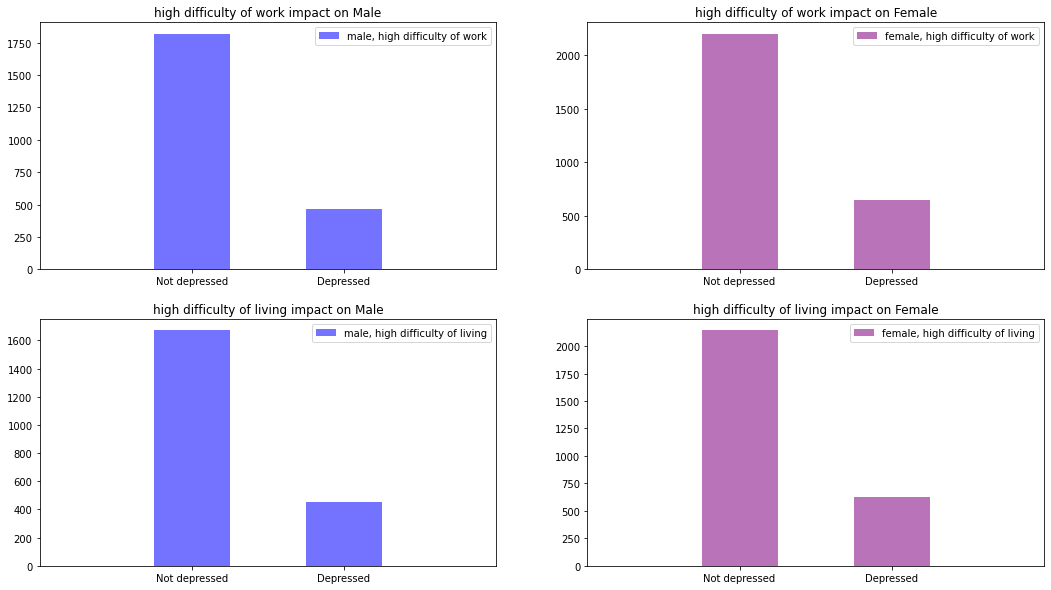

In [15]:
plt.figure(figsize=(18, 10))
plt.subplot(2,2,1)
male_diff_work = train_df.depression[train_df.gender == 1][train_df.difficulty_work >= 4].value_counts()
male_diff_work.plot(kind='bar', label='male, high difficulty of work', alpha=0.55, color='blue')
plt.title("high difficulty of work impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_diff_work))
plt.legend(loc='best')

plt.subplot(2,2,2)
female_diff_work = train_df.depression[train_df.gender == 2][train_df.difficulty_work >= 4].value_counts()
female_diff_work.plot(kind='bar', label='female, high difficulty of work', alpha=0.55, color='purple')
plt.title("high difficulty of work impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_diff_work))
plt.legend(loc='best')

plt.subplot(2,2,3)
male_diff_live = train_df.depression[train_df.gender == 1][train_df.difficulty_living >= 4].value_counts()
male_diff_live.plot(kind='bar', label='male, high difficulty of living', alpha=0.55, color='blue')
plt.title("high difficulty of living impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_diff_live))
plt.legend(loc='best')

plt.subplot(2,2,4)
female_diff_live = train_df.depression[train_df.gender == 2][train_df.difficulty_living >= 4].value_counts()
female_diff_live.plot(kind='bar', label='female, high difficulty of living', alpha=0.55, color='purple')
plt.title("high difficulty of living impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_diff_live))
plt.legend(loc='best')

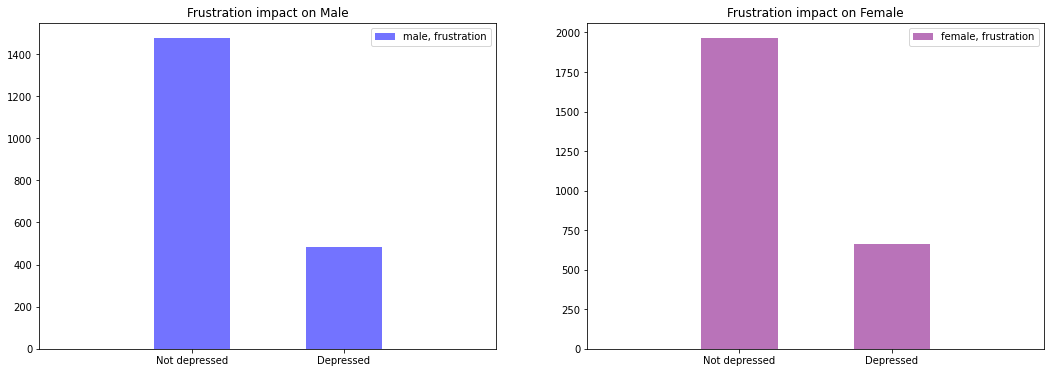

In [16]:
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
male_frustration = train_df.depression[train_df.gender == 1][train_df.frustration >= 4].value_counts()
male_frustration.plot(kind='bar', label='male, frustration', alpha=0.55, color='blue')
plt.title("Frustration impact on Male")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(male_frustration))
plt.legend(loc='best')

plt.subplot(1,2,2)
female_frustration = train_df.depression[train_df.gender == 2][train_df.frustration >= 4].value_counts()
female_frustration.plot(kind='bar', label='female, frustration', alpha=0.55, color='purple')
plt.title("Frustration impact on Female")
plt.xticks([0, 1],["Not depressed","Depressed"], rotation=0)
plt.xlim(-1, len(female_frustration))
plt.legend(loc='best')

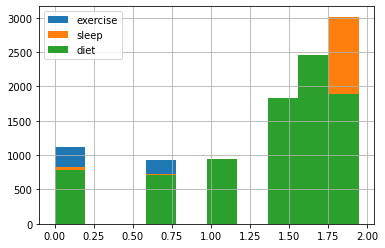

In [17]:
train_df["exercise"].apply(np.log).hist()
train_df["healthy_sleep"].apply(np.log).hist()
train_df["healthy_diet"].apply(np.log).hist()
plt.legend(['exercise', 'sleep', 'diet'])
plt.show()

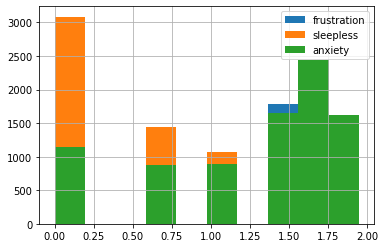

In [18]:
train_df["frustration"].apply(np.log).hist()
train_df["covid_sleepless"].apply(np.log).hist()
train_df["covid_anxiety"].apply(np.log).hist()
plt.legend(['frustration', 'sleepless', 'anxiety'])
plt.show()

In [19]:
X = train_df.drop(['id', 'depression'], axis = 1).values

Y = train_df['depression'].values
print(X.shape)
print(Y.shape)                  

(8610, 27)
(8610,)


In [20]:
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.10, random_state=0, shuffle = True)
print(train_x.shape)
print(valid_x.shape)

(7749, 27)
(861, 27)


In [51]:
#without oversampling (3-fold cross-validation)
classifier = XGBClassifier(n_thread = -1, tree_method='gpu_hist')
param_grid = {
    "n_estimators" : np.arange(100, 500, 50),
    "max_depth" : np.arange(3, 6, 1),
    "colsample_bytree": np.arange(0.5,1, 0.1),
    "criterion": ["gini",'entropy']
}

model = RandomizedSearchCV(estimator = classifier,
                          param_distributions = param_grid,
                          n_iter = 10,
                          scoring = "recall",
                          verbose = 10,
                          n_jobs = -1,
                          cv = 3)

model.fit(train_x, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, n_thread=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg...
                                           tree_method='gpu_hist',
                                           verbosity=1),
                   iid='deprecated', n_iter=10, n_job

In [45]:
accuracy_test = accuracy_score(valid_y, model.predict(valid_x))
print("Accuracy on test %.2f%%" % (accuracy_test * 100))
print("Classification report : ", classification_report(valid_y, model.predict(valid_x)))
print("Confusion Matrix : ", confusion_matrix(valid_y, model.predict(valid_x)))

Accuracy on test 83.51%
Classification report :                precision    recall  f1-score   support

           0       0.86      0.95      0.90       698
           1       0.62      0.33      0.43       163

    accuracy                           0.84       861
   macro avg       0.74      0.64      0.67       861
weighted avg       0.81      0.84      0.81       861

Confusion Matrix :  [[666  32]
 [110  53]]


In [46]:
test_df = pd.read_csv(test_dir)
print(test_df.head(5))
print(test_df.shape)
print(test_df.columns)

           id  city  ...  difficulty_living  difficulty_work
0   828763412     3  ...                  5                2
1  2009293273     2  ...                  1                5
2   360753013     1  ...                  2                3
3   321912830     3  ...                  6                5
4  1090960107     7  ...                  7                7

[5 rows x 28 columns]
(2723, 28)
Index(['id', 'city', 'gender', 'age', 'job', 'health_worker_self',
       'health_worker_family', 'family_status', 'income_group',
       'current_physical', 'past_physical', 'current_mental', 'past_mental',
       'exercise', 'healthy_diet', 'healthy_sleep', 'activity',
       'interaction_offline', 'interaction_online', 'preventive_behaviors',
       'optimism', 'deterioration_economy', 'deterioration_interact',
       'frustration', 'covid_anxiety', 'covid_sleepless', 'difficulty_living',
       'difficulty_work'],
      dtype='object')


In [47]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2723 entries, 0 to 2722
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2723 non-null   int64  
 1   city                    2723 non-null   int64  
 2   gender                  2723 non-null   int64  
 3   age                     2723 non-null   int64  
 4   job                     2723 non-null   int64  
 5   health_worker_self      2723 non-null   int64  
 6   health_worker_family    2723 non-null   int64  
 7   family_status           2723 non-null   int64  
 8   income_group            2344 non-null   float64
 9   current_physical        2723 non-null   int64  
 10  past_physical           2723 non-null   int64  
 11  current_mental          2723 non-null   int64  
 12  past_mental             2723 non-null   int64  
 13  exercise                2723 non-null   int64  
 14  healthy_diet            2723 non-null   

In [48]:
test_df.describe()

,id,city,gender,age,job,health_worker_self,health_worker_family,family_status,income_group,current_physical,past_physical,current_mental,past_mental,exercise,healthy_diet,healthy_sleep,activity,interaction_offline,interaction_online,preventive_behaviors,optimism,deterioration_economy,deterioration_interact,frustration,covid_anxiety,covid_sleepless,difficulty_living,difficulty_work
count,2.723000e+03,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2344.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000
mean,1.084098e+09,3.453177,1.519647,46.760558,1.623210,1.947852,1.915902,1.627249,4.396758,1.961072,1.929490,1.945281,1.879545,4.132574,4.309952,4.529563,4.056188,3.617701,3.380095,5.253397,4.001102,3.777084,2.684539,3.423797,4.008814,2.752112,3.636063,3.854205
std,6.234657e+08,2.019448,0.499706,13.966448,1.125715,0.222367,0.277586,0.483625,2.694188,0.193458,0.256052,0.227473,0.325553,1.827130,1.668791,1.849834,1.734849,1.913737,1.993155,1.849713,1.656483,1.868539,1.725465,1.789320,1.739436,1.727344,1.898445,2.020934
min,2.022402e+06,1.000000,1.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.440962e+08,2.000000,1.000000,36.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000,4.000000,3.000000,2.000000,1.000000,2.000000,3.000000,1.000000,2.000000,2.000000
50%,1.077848e+09,3.000000,2.000000,46.000000,1.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,4.000000,5.000000,5.000000,4.000000,4.000000,3.000000,6.000000,4.000000,4.000000,2.000000,4.000000,4.000000,2.000000,4.000000,4.000000
75%,1.639266e+09,5.000000,2.000000,56.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,7.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000
max,2.147206e+09,7.000000,2.000000,88.000000,5.000000,2.000000,2.000000,2.000000,10.000000,2.000000,2.000000,2.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [49]:
test_id = test_df['id'].values
print(test_id.shape)
test_x = test_df.drop(['id'], axis = 1).values
print(test_x.shape)

(2723,)
(2723, 27)


In [50]:
output_submission = pd.DataFrame(zip(test_id, model.predict_proba(test_x)[:,1]), columns = ['id','depression'])
output_submission.to_csv('/content/drive/MyDrive/Datathon/TEAM1_BitsNBytes_xgboost_3fold_all_data.csv',index=False)